# Name Generation Model- Using Recurrent Neural Network

A Recurrent Neural Network Model that generates human names based on existing data. The entire model is implemented using Tensorflow library

In [14]:

import pandas as pd 
import numpy as np 
import os 
import string
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Input
from tensorflow.keras.models import Sequential



# Loading the data 
The data file is downloaded from kaggle.

In [2]:
#loading the data
file_name = "Names.txt"
with open (file_name, "r") as f:
    names = f.read().lower()[:-1].split("\n")
print("Number of names:", len(names))
print("Max length:", max(map(len, names)))


Number of names: 55691
Max length: 25


# Preprocessing of Data for Input
Blank to start the name on input and Blank to end the name of output will be the format of training data
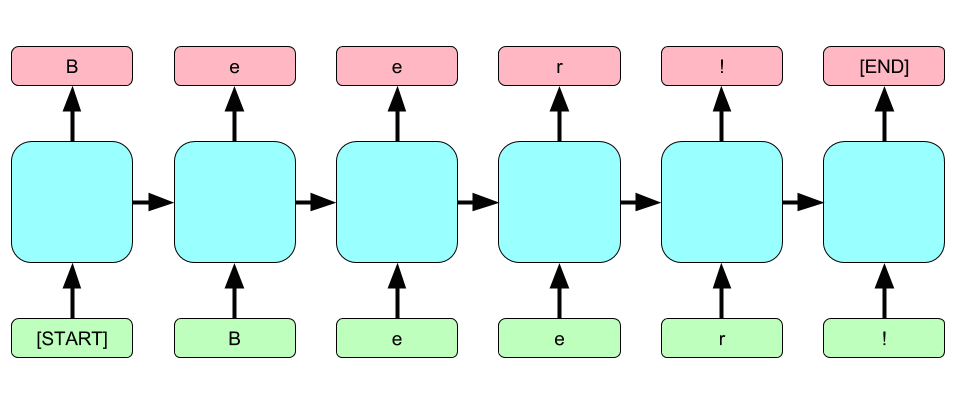

In [3]:
#taking the names having length less than or equal to 10
MAX_LENGTH = 10
names = [name for name in names if len(name) <= MAX_LENGTH]
print("Number of names:", len(names))
# start and padding tokens for beginning and end of the names
start_token = " "
pad_token = "#"
names = [start_token + name for name in names]
MAX_LENGTH+=1


Number of names: 48251


In [4]:
#Number of unique characters in the names + padding token + start token
tokens = sorted(set("".join(names+[pad_token])))
n_tokens = len(tokens)
print("n_tokens:", n_tokens)
print("tokens:", tokens)


n_tokens: 30
tokens: [' ', '#', '-', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
#creating a dictionary for token to id and id to token
token_to_id = {token: i for i, token in enumerate(tokens)}
id_to_token = {i: token for i, token in enumerate(tokens)}
print("token_to_id:", token_to_id)


token_to_id: {' ': 0, '#': 1, '-': 2, '.': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}


# Creating the input for the model

In [6]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix
    
print("".join(names[::5000]))
print(to_matrix(names[::5000]))


 aaban dousik kapith pratamesh seker yathunan divi kaliani nishaari thileena
[[ 0  4  4  5  4 17  1  1  1  1]
 [ 0  7 18 24 22 12 14  1  1  1]
 [ 0 14  4 19 12 23 11  1  1  1]
 [ 0 19 21  4 23  4 16  8 22 11]
 [ 0 22  8 14  8 21  1  1  1  1]
 [ 0 28  4 23 11 24 17  4 17  1]
 [ 0  7 12 25 12  1  1  1  1  1]
 [ 0 14  4 15 12  4 17 12  1  1]
 [ 0 17 12 22 11  4  4 21 12  1]
 [ 0 23 11 12 15  8  8 17  4  1]]


In [7]:
X = to_matrix(names)
print(X.shape)

(48251, 11)


In [8]:
X_train = np.zeros((X.shape[0],X.shape[1],n_tokens),np.int32)
y_train = np.zeros((X.shape[0],X.shape[1],n_tokens),np.int32)
for i, name in enumerate(X):
    
    for j in range(MAX_LENGTH-1):
        X_train[i,j,name[j]] = 1
        y_train[i,j,name[j+1]] = 1
    X_train[i,MAX_LENGTH-1,name[MAX_LENGTH-1]] = 1
    y_train[i,MAX_LENGTH-1,token_to_id[pad_token]] = 1
print(X_train.shape)


(48251, 11, 30)


In [9]:
name_count = X.shape[0]
print("Number of training examples:", name_count)  


Number of training examples: 48251


# Trying to implement the RNN from scratch

In [10]:
class RNN:
    def __init__(self,hidden_size,vocab_size,seq_length,learning_rate):
        #hyper parameters
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.U = np.random.randn(hidden_size,vocab_size) #input to hidden
        self.W = np.random.randn(hidden_size,hidden_size)
        self.V = np.random.randn(vocab_size,hidden_size)
        self.b = np.random.randn(hidden_size,1)
        self.c = np.random.randn(vocab_size,1)

    def softmax(self,x):
        exps = np.exp(x-np.max(x))
        return exps/np.sum(exps)

    def forward(self,inputs, hprev):
        xs, hs, os, ycap = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        for t in range((len(inputs))):
            xs[t] = np.zeros((vocab_size,1)) #creating an input vector for each character in the sequence
            xs[t][inputs[t]] = 1 #one hot encoding
            hs[t] = np.tanh(np.dot(self.U, xs[t]) + np.dot(self.W, hs[t-1]) + self.b)#hidden state and activation function tanh applied
            os[t] = np.dot(self.V, hs[t]) + self.c #unnormalized log probabilities for next chars
            ycap[t] = self.softmax(self.os[t])#output layer
        return xs, hs,ycap
    
    def loss(self,ycap,targets):
        return sum(-np.log(ycap[t][targets[t],0]) for t in range(len(targets)))
    
    def backward(self, xs, hs, ycap, targets):
        dU, dW, dV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        db, dc = np.zeros_like(self.b), np.zeros_like(self.c)
        dhnext = np.zeros_like(hs[0])
        for t in reversed(range(len(targets))):
            dy = np.copy(ycap[t])
            dy[targets[t]] -= 1
            dV += np.dot(dy, hs[t].T)
            dc += dy
            dh = np.dot(self.V.T, dy) + dhnext
            dhraw = (1 - hs[t] * hs[t]) * dh
            db += dhraw
            dU += np.dot(dhraw, xs[t].T)
            dW += np.dot(dhraw, hs[t-1].T)
            dhnext = np.dot(self.W.T, dhraw)
        for dparam in [dU, dW, dV, db, dc]:
            np.clip(dparam, -5, 5, out=dparam)
        return dU, dW, dV, db, dc, hs[len(targets)-1]
    
    def update_model(self, dU, dW, dV, db, dc):
        for param, dparam in zip([self.U, self.W, self.V, self.b, self.c], [dU, dW, dV, db, dc]):
            param += -self.learning_rate * dparam
    
    def sample(self,char_to_ix, seed):
        x = np.zeros((self.vocab_size, 1))
        a_prev = np.zeros((self.hidden_size,1))
        indices = []
        idx = -1
        counter =0
        new_line_character = char_to_ix['\n']

        while(idx!= new_line_character and counter !=50):
            
            a = np.tanh(np.dot(self.U,x) + np.dot(self.W,a_prev) + self.b)
            z=np.dot(self.V,a) + self.c
            y=self.softmax(z)

            np.random.seed(counter+seed)

            idx = np.random.choice(range(self.vocab_size), p=y.ravel())
            indices.append(idx)
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
            a_prev = a
            counter +=1
            seed +=1
        if(counter == 50):
            indices.append(new_line_character)
        return indices


# Initializing the Model 

In [12]:
BATCH_SIZE = 64
steps_per_epoch = name_count // BATCH_SIZE

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X,y_train))
    .shuffle(5000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO))
hidden_layers = 128
embedding_size = 16


In [16]:
model = Sequential()
model.add(Input(shape=(MAX_LENGTH,)))
model.add(Embedding(n_tokens, embedding_size))
model.add(SimpleRNN(hidden_layers, return_sequences=True,activation='tanh'))
model.add(SimpleRNN(hidden_layers, return_sequences=True,activation='tanh'))
model.add(Dense(n_tokens, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 16)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 11, 128)        │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 11, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11, 30)         │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,806 (217.99 KB)

 Trainable params: 55,806 (217.99 KB)

 Non-trainable params: 0 (0.00 B)

None


# Training the model

In [17]:
EPOCHS = 100
history = model.fit(train_dataset,steps_per_epoch=steps_per_epoch,epochs=EPOCHS)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4921 - loss: 1.7926
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5415 - loss: 1.5305
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5509 - loss: 1.4853
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5570 - loss: 1.4584
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5614 - loss: 1.4395
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5656 - loss: 1.4202
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5685 - loss: 1.4097
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5705 - loss: 1.3981
Epoch 9/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5726 - loss: 1.3890
Epoch 10/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5746 - loss: 1.3796
Epoch 11/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5762 - loss: 1.3728
Epoch 12/100
753/753 ━━━━━━━━━━━━━━━━━━━━

# Generating names using the trained model with specific seed phrase

In [18]:
def generateName(model, seed_phrase=" ", max_length=MAX_LENGTH):
    name = [seed_phrase]
    x = np.zeros((1,max_length),np.int32)
    x[0,0:len(seed_phrase)] = [token_to_id[token] for token in seed_phrase]
    for i in range(len(seed_phrase),max_length):  
        
        probs = list(model.predict(x)[0,i-1])
        
        probs = probs/np.sum(probs)
        
        index = np.random.choice(range(n_tokens),p=probs)
        
        if index == token_to_id[pad_token]:
            break
            
        x[0,i] = index
        
        name.append(tokens[index])
    
    return "".join(name)


In [19]:
seed_phrase = " "
for _ in range(40):
    name = generateName(model,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
manral (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
maruballi (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━

In [22]:
seed_phrase = " a"
for _ in range(20):
    name = generateName(model,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
aruaviriya (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
aswina
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ajaima (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1

In [23]:
seed_phrase = " b"
for _ in range(20):
    name = generateName(model,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
bakula
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
blina (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
biniaana (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━

In [24]:
seed_phrase = " aa"
for _ in range(20):
    name = generateName(model,seed_phrase=seed_phrase)
    if name not in names:
        print(f"{name.lstrip()} (New Name)")
    else:
        print(name.lstrip())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
aanavi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
aaryarega (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
aaruthya (New Name)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/